# Import Libraries

In [1]:
from google.colab import drive
import sys
import pandas as pd

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
drive.mount('drive')

Mounted at drive


In [4]:
base_path = '/content/drive/MyDrive/dialect_classification/'

In [5]:
sys.path.append(base_path + 'training/data_preparation/')

# Fetch Data

first we will need to read the database tables into dataframes

In [6]:
from fetch_data import fetch_text_labels

In [7]:
dataset_path = base_path + 'dataset/dialects_database.db'

In [8]:
text, labels = fetch_text_labels(dataset_path)

# EDA

join both tables for visualizations

In [9]:
data = text.join(labels)

from the info of the data we see that there are no null values

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147725 entries, 1009754958479151232 to 981080482380238848
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    147725 non-null  object
 1   label   147725 non-null  object
dtypes: object(2)
memory usage: 7.4+ MB


In [20]:
data.duplicated().sum()

0

In [25]:
data.duplicated(subset='text').sum()

0

from the description of the data we notice there are 5 classes for the labels and there are no duplicates in the text column

In [14]:
data.describe()

,text,label
count,147725,147725
unique,147725,5
top,@toha_Altomy @gy_yah قليلين ادب ومنافقين. لو ا...,EG
freq,1,57636


The 5 classes are:
- EG: Egypt
- LY: Lybia
- LB: Lebanon
- SD: Sudan
- MA: Maghreb

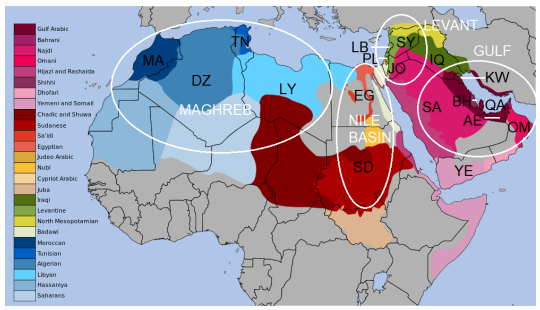

We notice there is a great imbalance in the data

<Axes: >

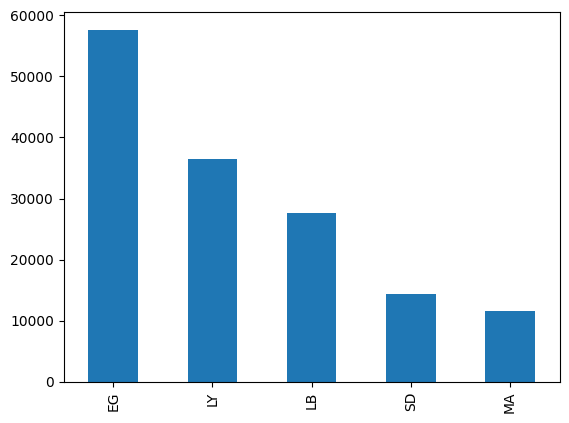

In [15]:
data['label'].value_counts().plot.bar()

In [19]:
data.sample(20)

,text,label
id,,
1100976677474234368,@HajerOsmaan السمسم دفق\nماشاءالله ربنا يحفظكم,SD
886989008454250496,الحمصة قالت زعما يجي يوم ويحلل الشرع 4 للمرأة \nانت ليش متعبه روحك يا حمصه انت محسوبه علي التريس خشي على 4,LY
1007018726145830784,@simon10310107 وانت بصحة وسعادة سيمون,EG
1168663718680518912,حد يصحى الوطنين اللى بيقولوا ان الفديوهات دى مش فى مصر https://t.co/X080cN01yV,EG
1103286913602080768,واضح ان حضرتك بتتريق فياريت بلاش تستهزءوا بآلام الناس ممكن تكون شايف الموضوع تافة من وجهة نظرك لكن هو قوي وعنيف بالنسبة للبسكوتة جيب حتة فحم وارسم حواجب وحط نفسك مكانها هتلاقيك متعاطف مع مشكلتها جداً https://t.co/m60kt519Pa,EG
829017714186285056,"@mabdulhamidBBC تصحيح للمعلومة كلمة ""ختان"" مش صحيحة",EG
1144591679174979584,@HajerLy2 اللهم امين...ماتعرفش خيرى لين تجرب غيري.. وهذا لى صاير توا جورى .💕.كان يحارب فيهم على خاطر عارفهم جهلة مايعرفوش حتى الباب من وين يفتح 😔😔😔💔,LY
932604140567564416,@MatogSaleh @ChangeInLibya باهي توا سناء يوسف محيدلي اللي زمان قرينا عنها و قادت سيارة مفخخة فيها أطنان من المواد المتفجرة و استهدفت تجمعا للجيش للاسرائيلي و فجرتها وسطهم نعتبروها مناضلة و فدائية عربية و لا انتحارية و لا شنو ؟!,LY
1172826085203087360,رب ضارة نافعه..\nاللي بيعملوه ارتد عليهم..\nاولا..الناس لاول مره مهتمه جدا بمؤتمر الشباب ده وقاعدين بيتابعوه\nثانيا.السيسي قرر يضرب الهارد وير كله بتاع السوشيال مش بس يرد ع الكلام الفارغ\nثالثا.واضح ان الموضوع له ابعاد اخري خفيه وان ما يظهر هو قمة جبل الجليد,EG


After looking at multiple observations, we came with the following preprocessing:
1. remove tags
2. remove emojiis
3. remove puncituation
4. remove links
5. remove diacritics
6. remove elongation
7. remove english words
8. remove white spaces (\n, \t)
9. remove numbers (english or arabic)
10. remove hashtags
11. normalize characters (ء, ا, أ)

# Data Preprocessing

In [13]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=ad2212c8bb8683aa6b2f3f28a2d3fab5086d088d82d48a0299f7c4475fc4a239
  Stored in directory: /root/.cache/pip/wheels/02/3d/88/51a592b9ad17e7899126563698b4e3961983ebe85747228ba6
Successfully built emoji


In [14]:
from preprocess_data import *

we will subset a sample of the data to perform preprocessing on it

In [11]:
original_sample_data = data.sample(20)

In [12]:
original_sample_data

,text,label
id,,
1118201401799257984,@elbetrek @Farida66640001 عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,@RussellKeloua @elhajjmalcolmx العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع .. انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم #لبنان_يثور,LB
1155944449354022912,@Esrae100 اكيد ابنتها لان زوجه ابنها ستظل غريبه ....وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول ....,EG
969857032282148864,انا: يا اكسبنسف ،بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف: عنجد حياتسي هلقد بيلمعو !!!\nانا: لا والله ما بيلمعو بس كل سن بجهة\n\n#hi_its_me\n#ابكي_علي_يا_مراتو_جوزك_روّح_...,LB
1135957681930407936,@carolinefawzi اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا 3 متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع 20 سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,@nbenotman بلكي واخذ منه شي او شايفك تاكل في فاكهة ....للأذكياء فقط,LY
920656894301175808,@azizq884 سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


In [13]:
def print_result(data_sample, text_preprocess):
  data = data_sample.copy()
  data['text'] = data['text'].apply(text_preprocess)
  return data

## Remove Tags

In [14]:
sample_data = print_result(original_sample_data, remove_tags)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع .. انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم #لبنان_يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه ....وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول ....,EG
969857032282148864,انا: يا اكسبنسف ،بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف: عنجد حياتسي هلقد بيلمعو !!!\nانا: لا والله ما بيلمعو بس كل سن بجهة\n\n#hi_its_me\n#ابكي_علي_يا_مراتو_جوزك_روّح_...,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا 3 متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع 20 سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة ....للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove Numbers

In [15]:
sample_data = print_result(sample_data, remove_numbers)
sample_data
#1002231117041332224

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع .. انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم #لبنان_يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه ....وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول ....,EG
969857032282148864,انا: يا اكسبنسف ،بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف: عنجد حياتسي هلقد بيلمعو !!!\nانا: لا والله ما بيلمعو بس كل سن بجهة\n\n#hi_its_me\n#ابكي_علي_يا_مراتو_جوزك_روّح_...,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة ....للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove Links

In [16]:
sample_data = print_result(sample_data, remove_links)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع .. انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم #لبنان_يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه ....وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول ....,EG
969857032282148864,انا: يا اكسبنسف ،بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف: عنجد حياتسي هلقد بيلمعو !!!\nانا: لا والله ما بيلمعو بس كل سن بجهة\n\n#hi_its_me\n#ابكي_علي_يا_مراتو_جوزك_روّح_...,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة ....للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove English words

In [17]:
sample_data = print_result(sample_data, remove_english_characters)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع .. انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم #لبنان_يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه ....وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول ....,EG
969857032282148864,انا: يا اكسبنسف ،بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف: عنجد حياتسي هلقد بيلمعو !!!\nانا: لا والله ما بيلمعو بس كل سن بجهة\n\n# _ _ \n#ابكي_علي_يا_مراتو_جوزك_روّح_...,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة ....للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove punctuation

In [18]:
sample_data = print_result(sample_data, remove_punctuation)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم لبنان يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول,EG
969857032282148864,انا يا اكسبنسف بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف عنجد حياتسي هلقد بيلمعو \nانا لا والله ما بيلمعو بس كل سن بجهة\n\n \n ابكي علي يا مراتو جوزك روّح,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove diacritics

In [19]:
remove_diacritics("وَٱلَّذِينَ يُؤْمِنُونَ بِمَآ أُنزِلَ إِلَيْكَ وَمَآ أُنزِلَ مِن قَبْلِكَ وَبِٱلْـَٔاخِرَةِ هُمْ يُوقِنُونَ")

'وٱلذين يؤمنون بمآ أنزل إليك ومآ أنزل من قبلك وبٱلٔاخرة هم يوقنون'

In [20]:
remove_diacritics("فَصَبْرٌ جَمِيلٌ وَاللَّهُ الْمُسْتَعَانُ عَلَى مَا تَصِفُونَ")

'فصبر جميل والله المستعان على ما تصفون'

In [21]:
sample_data = print_result(sample_data, remove_diacritics)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم لبنان يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه وبعدين الافكار ده والمفروض مين كان زمااان واوي كمان بس زوجه ابنها تراعيه الاول,EG
969857032282148864,انا يا اكسبنسف بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف عنجد حياتسي هلقد بيلمعو \nانا لا والله ما بيلمعو بس كل سن بجهة\n\n \n ابكي علي يا مراتو جوزك روح,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove elongation

In [22]:
def remove_repeating_char02(text):
    return re.sub(r'(.+)\1{2,}', r'\1', text)
remove_repeating_char02('الله يسلمك ويكرمك ويرفع قدرك\nتسلم كلك ذوق	')

'الله يسلمك ويكرمك ويرفع قدرك\nتسلم كلك ذوق\t'

In [23]:
remove_repeating_char02('هيهيهيهيهيهيهيهيه انا رجعت وربنا يخليني لكم ومايحرمكم مني ابدا ولا يحرمني منكم بحبكم اصدقاءي	')

'هيهيه انا رجعت وربنا يخليني لكم ومايحرمكم مني ابدا ولا يحرمني منكم بحبكم اصدقاءي\t'

In [24]:
sample_data = print_result(sample_data, remove_repeating_char)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت\nقدام قهوة ذغلولمكتوب عليها\nتعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم لبنان يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه وبعدين الافكار ده والمفروض مين كان زمان واوي كمان بس زوجه ابنها تراعيه الاول,EG
969857032282148864,انا يا اكسبنسف بتصدقي انو سنانك متل النجوم اللي بالسما\nالاكسبسف عنجد حياتسي هلقد بيلمعو \nانا لا والله ما بيلمعو بس كل سن بجهة\n\n \n ابكي علي يا مراتو جوزك روح,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Remove tabs and new lines

In [25]:
sample_data = print_result(sample_data, remove_tabs_and_new_lines)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت قدام قهوة ذغلولمكتوب عليها تعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحية الشغل لا حدا بيدقلي يقلي نزال ولا طلاع انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم لبنان يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه وبعدين الافكار ده والمفروض مين كان زمان واوي كمان بس زوجه ابنها تراعيه الاول,EG
969857032282148864,انا يا اكسبنسف بتصدقي انو سنانك متل النجوم اللي بالسما الاكسبسف عنجد حياتسي هلقد بيلمعو انا لا والله ما بيلمعو بس كل سن بجهة ابكي علي يا مراتو جوزك روح,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهة للأذكياء فقط,LY
920656894301175808,سؤال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجة الوحيدة اللي مايقولوش منين جبتوهانا الجمع بين الصلاة في المطر😂,LY


## Normaliza characters

In [26]:
sample_data = print_result(sample_data, normalize_arabic)
sample_data

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت قدام قهوه ذغلولمكتوب عليها تعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحيه الشغل لا حدا بيدقلي يقلي نزال ولا طلاع انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم لبنان يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه وبعدين الافكار ده والمفروض مين كان زمان واوي كمان بس زوجه ابنها تراعيه الاول,EG
969857032282148864,انا يا اكسبنسف بتصدقي انو سنانك متل النجوم اللي بالسما الاكسبسف عنجد حياتسي هلقد بيلمعو انا لا والله ما بيلمعو بس كل سن بجهه ابكي علي يا مراتو جوزك روح,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل😍😍,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهه للاذكياء فقط,LY
920656894301175808,سءال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجه الوحيده اللي مايقولوش منين جبتوهانا الجمع بين الصلاه في المطر😂,LY


## Remove emojies

In [27]:
print_result(sample_data, remove_emojis)

,text,label
id,,
1118201401799257984,عند موقف الاتوبي سوبرجيت قدام قهوه ذغلولمكتوب عليها تعاود بالسلامه ياعلوان,EG
1013916575148199936,العفو اخويا مرحبا والف مرحبا هانيا,MA
1186023192533655552,انا مرتاح من ناحيه الشغل لا حدا بيدقلي يقلي نزال ولا طلاع انا فاتني القطار بس نازل كرمال ابني بكرا بس يكبر يلاقي شغل بدون ما يبوس طيز حدا منكم لبنان يثور,LB
1155944449354022912,اكيد ابنتها لان زوجه ابنها ستظل غريبه وبعدين الافكار ده والمفروض مين كان زمان واوي كمان بس زوجه ابنها تراعيه الاول,EG
969857032282148864,انا يا اكسبنسف بتصدقي انو سنانك متل النجوم اللي بالسما الاكسبسف عنجد حياتسي هلقد بيلمعو انا لا والله ما بيلمعو بس كل سن بجهه ابكي علي يا مراتو جوزك روح,LB
1135957681930407936,اصعب حادثه شوفتها سياره اسعاف فاتحه السرينه وطايره ومعروف كله يوسع جه واحد بمسيكل طاير برضه في التقاطع شالته طار تقريبا متر لفوق ونزل علي دماغه الاسعاف الي رايحه تنقذ مريض بقي قدامها قتيل في دقيقه بعد مكالمه في الاسلكي جم بتاع سياره اسعاف كله جاي يجامل,EG
585552479460450304,بلكي واخذ منه شي او شايفك تاكل في فاكهه للاذكياء فقط,LY
920656894301175808,سءال محيرني ومش ملاقي جواب عليه,LB
1058371959472472064,الشيابين في الجامع الحاجه الوحيده اللي مايقولوش منين جبتوهانا الجمع بين الصلاه في المطر,LY


In [28]:
remove_repeating_char('هيهيهيهيهيهيهيهيه انا رجعت وربنا يخليني لكم ومايحرمكم مني ابدا ولا يحرمني منكم بحبكم اصدقاءي	')

'هيهيه انا رجعت وربنا يخليني لكم ومايحرمكم مني ابدا ولا يحرمني منكم بحبكم اصدقاءي\t'

# Apply all the preprocessing on the whole data

In [15]:
preprocessed_data = data.copy()

In [16]:
preprocessed_data['text'] = preprocessed_data['text'].apply(preprocess_text)

## Validate the preprocessed data

In [17]:
preprocessed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147725 entries, 1009754958479151232 to 981080482380238848
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    147725 non-null  object
 1   label   147725 non-null  object
dtypes: object(2)
memory usage: 7.4+ MB


In [28]:
preprocessed_data['label'].isna().sum()

0

In [29]:
preprocessed_data['text'].isna().sum()

0

### check & handle duplicated values

In [19]:
preprocessed_data.duplicated().sum()

6

In [24]:
duplicated_mask = preprocessed_data.duplicated(keep=False)
preprocessed_data[duplicated_mask]

,text,label
id,,
1144579774926524416,حتي والخاطر مخنوق يشم هوا صبراته يروق,LY
961260217689354240,حتي والخاطر مخنوق يشم هوا صبراته يروق,LY
1126224573500919808,بتحط نفسك في مواقف بايخه,LY
922450944079663232,بتحط نفسك في مواقف بايخه,LY
1175123413029011712,يا مسهل الحال يارب,EG
963792090420441216,يا مسهل الحال يارب,EG
563447805419999232,ورغم ان الكلام اصلا بينقص حاجه كل ما زاد,EG
524467389778640896,ورغم ان الكلام اصلا بينقص حاجه كل ما زاد,EG
1060571247820636160,هو ده اللي انا بقوله,EG


In [21]:
preprocessed_data.duplicated(subset=['text']).sum()

12

In [23]:
duplicated_text_mask = preprocessed_data.duplicated(subset=['text'], keep=False)
preprocessed_data[duplicated_text_mask]

,text,label
id,,
1125738631551959040,شر البليه ما يضحك,LY
1144579774926524416,حتي والخاطر مخنوق يشم هوا صبراته يروق,LY
961260217689354240,حتي والخاطر مخنوق يشم هوا صبراته يروق,LY
1126224573500919808,بتحط نفسك في مواقف بايخه,LY
1120783523596599168,ايوا كدا يا وديع,LY
1163551399952691200,انا قلت كده برضو,LY
1113429336726614016,حب ايه اللي انت جاي تقول عليه,LY
922450944079663232,بتحط نفسك في مواقف بايخه,LY
1080397175752966016,عليه افضل الصلاه والسلام,MA


First we will remove the duplicated rows with same text and labels

In [32]:
new_preprocessed_data = preprocessed_data.drop_duplicates()

In [33]:
new_preprocessed_data.duplicated().sum()

0

Now let's investigate the duplicated text

In [34]:
new_preprocessed_data.duplicated(subset=['text']).sum()

6

In [38]:
duplicated_text_mask = new_preprocessed_data.duplicated(subset=['text'], keep=False)
new_preprocessed_data[duplicated_text_mask].sort_values('text')

,text,label
id,,
1163551399952691200,انا قلت كده برضو,LY
1185231489912524800,انا قلت كده برضو,LB
1120783523596599168,ايوا كدا يا وديع,LY
749075049903190016,ايوا كدا يا وديع,SD
1113429336726614016,حب ايه اللي انت جاي تقول عليه,LY
1187229934407880704,حب ايه اللي انت جاي تقول عليه,LB
1125738631551959040,شر البليه ما يضحك,LY
1003256455305269248,شر البليه ما يضحك,MA
1080397175752966016,عليه افضل الصلاه والسلام,MA


looking at the duplicated text we find that each one doesn't represent a certain dialect so we will leave it as it is so that the model learns that it doesn't belong to a certain dialect

### Save the preprocessed data

In [39]:
new_preprocessed_data.to_csv(base_path+'training/preprocessed_data_2.csv', index=False)

Make sure that saving has been done successfully by trying to read the data 

In [41]:
try_read = pd.read_csv(base_path+'training/preprocessed_data_2.csv', lineterminator='\n')

In [42]:
try_read.head()

,text,label
0,قليلين ادب ومنافقين لو اختهم او قريبتهم تتعاكس تقولي عليهم من نشاط حقوق المراه من رده فعلهم,LY
1,الليبيين متقلبين بس بالنسبه ليا انا ميليشياوي زمان وتوه,LY
2,كل تانيه شاب ليبي بيرتاح لبنت مختلفه ويلاحظ انها غير كل البنات وبيحس كانه يعرفها من زمان بعدين يتزوج وحده منهن وممكن اثنين ولاثلاثه وتنقلب الرومانسيه لعياط وشياط وتهزيب ذي اند,LY
3,رانيا عقليتك متخلفه اولا الانسان يلي يحتاج اهل يخاف منهم علشان يكون محترم هو انسان قليل الادب اصلا ثانيا شن ذنب يلي معندهش اب ولا ام ولا خوت ولا خوات يعني اليتيمه متستحقش تتزوج وثالثا ليش البنت هي بس لازم ادير الف حساب للراجل هي متستحقش يندارلها الف حساب ولا هي عبده,LY
4,شكلك متعقده علشان الراجل لي تحبيه ازوج بنت يتيمه ولا بنت معندهش خوت هدي اعصابك وفكينا من التخلف امتاعك,LY


In [43]:
try_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147719 entries, 0 to 147718
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    147719 non-null  object
 1   label   147719 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


In [47]:
try_read['label'].isna().sum()

0

In [48]:
try_read['text'].isna().sum()

0

In [49]:
try_read.duplicated().sum()

0

In [50]:
try_read.duplicated(subset='text').sum()

6